In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

features = [     
    'Make',
    'Model',
    'Year',
    'Engine HP',
    'Engine Cylinders',
    'Transmission Type',
    'Vehicle Style',
    'highway MPG',
    'city mpg',
    'MSRP'
]

df = pd.read_csv('chapter04-eval-data.csv')
df = df[ features ]
df.columns = df.columns.str.replace(' ', '_').str.lower()
df = df.fillna(0)
#df.isnull().sum()

In [2]:
priceMean = df['msrp'].mean()
print( "priceMean = ", priceMean)
df[ 'above_average' ] = (df['msrp'] > priceMean ) + 0
del df['msrp']

priceMean =  40594.737032063116


In [3]:
seed = 1
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=seed)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=seed)

y_train = df_train[ 'above_average' ]
y_val = df_val[ 'above_average' ]

del df_train[ 'above_average' ]
del df_val[ 'above_average' ]


In [4]:
# train and predict functions

def train(df_train, y_train, C=1.0):
    dicts = df_train[categoricalFeatures + numericalFeatures].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categoricalFeatures + numericalFeatures].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [5]:
numericalFeatures = [ 'year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg' ]
categoricalFeatures = [ 'make', 'model', 'transmission_type', 'vehicle_style' ]

Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

    For each numerical variable, use it as score and compute AUC with the above_average variable
    Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

    engine_hp
    engine_cylinders
    highway_mpg
    city_mpg
    
ANSWER: engine_hp


In [6]:
#dv = DictVectorizer(sparse=False)

#train_dict = df_train[categoricalFeatures + numericalFeatures].to_dict(orient='records')
#X_train = dv.fit_transform(train_dict)

for feature in numericalFeatures:
    model = LogisticRegression()
    model.fit(df_train[feature].to_frame(), y_train)
    y_train_pred = model.predict(df_train[feature].to_frame())
    #display( y_train )
    #display(y_train_pred )
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    auc_score = roc_auc_score(y_train, y_train_pred)
    auc_val = metrics.auc(fpr, tpr)
    print( "Feature: ", feature, " auc score: ", auc_score, " auc: ", auc_val )

Feature:  year  auc score:  0.5  auc:  0.5
Feature:  engine_hp  auc score:  0.7944901528558269  auc:  0.7944901528558269
Feature:  engine_cylinders  auc score:  0.6821317811693173  auc:  0.6821317811693173
Feature:  highway_mpg  auc score:  0.5  auc:  0.5
Feature:  city_mpg  auc score:  0.5012800819252432  auc:  0.5012800819252432


In [7]:
print( "Just an experiment")
##for feature in numericalFeatures:
    #y_train = df_train[ 'above_average' ]
    #y_val = df_val[ 'above_average' ]

    #del df_train[ 'above_average' ]
    #del df_val[ 'above_average' ]
    
    ##dv, model = train(df_train[feature].to_frame(), y_train, C=1.0)
    #y_train_pred = predict(df_train[feature].to_frame(), dv, model)
    
    #model = LogisticRegression()
    #model.fit(df_train[feature].to_frame(), y_train)
    #y_train_pred = model.predict(df_train[feature].to_frame())
    #display( y_train )
    #display(y_train_pred )
    ##fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    ##auc_score = roc_auc_score(y_train, y_train_pred)
    ##auc_val = metrics.auc(fpr, tpr)
    ##print( "Feature: ", feature, " auc score: ", auc_score, " auc: ", auc_val )
    ##display( df_train[feature].to_frame() )

Just an experiment


Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

    0.678
    0.779
    0.878
    0.979
    
ANSWER: 0.971

In [8]:
train_dict = df_train[categoricalFeatures + numericalFeatures].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)
print( "Got X_train")

Got X_train


In [9]:
val_dict = df_val[categoricalFeatures + numericalFeatures].to_dict(orient='records')

#dv = DictVectorizer(sparse=False)
#dv.fit(val_dict)

X_val = dv.transform(val_dict)
print( "Got X_val")

Got X_val


In [10]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
#y_val_pred = model.predict(X_val)
y_val_pred = model.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_val_pred)
print( "auc_score: ", round( auc_score, 4 ) )

auc_score:  0.9797


In [11]:
# Variant using Alexey's functions

dv, model = train(df_train, y_train, C=1.0)
y_val_pred = predict(df_val, dv, model)

auc_score = roc_auc_score(y_val, y_val_pred)
print( "auc_score: ", round( auc_score, 3 ) )

auc_score:  0.98


Question 3: Precision and Recall

Now let's compute precision and recall for our model.

    Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
    For each threshold, compute precision and recall
    Plot them

At which threshold precision and recall curves intersect?

    0.28
    0.48
    0.68
    0.88
 
ANSWER:0.68

FOUND crt_c= 0.31  precision= 0.928  recall= 0.928
FOUND crt_c= 0.33  precision= 0.929  recall= 0.929
FOUND crt_c= 0.38  precision= 0.933  recall= 0.933
FOUND crt_c= 0.4  precision= 0.934  recall= 0.934
FOUND crt_c= 0.41  precision= 0.934  recall= 0.934
FOUND crt_c= 0.42  precision= 0.935  recall= 0.935
FOUND crt_c= 0.43  precision= 0.935  recall= 0.935
FOUND crt_c= 0.44  precision= 0.934  recall= 0.934
FOUND crt_c= 0.45  precision= 0.93  recall= 0.93
FOUND crt_c= 0.49  precision= 0.937  recall= 0.937
FOUND crt_c= 0.5  precision= 0.937  recall= 0.937
FOUND crt_c= 0.54  precision= 0.937  recall= 0.937
FOUND crt_c= 0.56  precision= 0.933  recall= 0.933
FOUND crt_c= 0.57  precision= 0.933  recall= 0.933
FOUND crt_c= 0.58  precision= 0.937  recall= 0.937
FOUND crt_c= 0.61  precision= 0.938  recall= 0.938
FOUND crt_c= 0.63  precision= 0.935  recall= 0.935
FOUND crt_c= 0.64  precision= 0.935  recall= 0.935
FOUND crt_c= 0.65  precision= 0.935  recall= 0.935
FOUND crt_c= 0.66  precision= 0.938

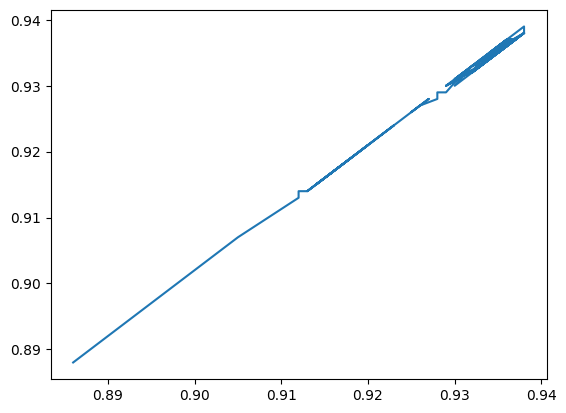

In [12]:
possible_answers = [0.28, 0.48, 0.68, 0.88]
precissionList = []
recallList = []

for crt_c in np.arange(0.01,1.0,0.01):
    # avoid the rounding error
    crt_c = round(crt_c,2)
    model = LogisticRegression(solver='liblinear', C=crt_c, max_iter=1000)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    #fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
    round_val = 3
    precision = round( precision_score(y_val, y_val_pred, average='weighted'), round_val)
    recall = round( recall_score(y_val, y_val_pred, average='weighted'), round_val)
    precissionList.append(precision)
    recallList.append(recall)
    if precision == recall:
        print("FOUND crt_c=", crt_c ," precision=", precision, " recall=", recall )
        if crt_c in possible_answers:
            print("FOUND IN LIST ", crt_c) 
    #if precision > recall:
    #    print(" P>R crt_c=", crt_c ," precision=", precision, " recall=", recall )
    #else:
    #    print("P<R crt_c=", crt_c," precision=", precision, " recall=", recall )
plt.plot(precissionList, recallList)
    

0.8310580204778157 0.7446483180428135
FOUND crt_c= 0.01  precision= 0.831  recall= 0.831
0.8449744463373083 0.7584097859327217
FOUND crt_c= 0.02  precision= 0.845  recall= 0.845
0.8654173764906303 0.7767584097859327
FOUND crt_c= 0.03  precision= 0.865  recall= 0.865
0.8636363636363636 0.7844036697247706
FOUND crt_c= 0.04  precision= 0.864  recall= 0.864
0.86 0.7889908256880734
FOUND crt_c= 0.05  precision= 0.86  recall= 0.86
0.8631921824104235 0.8103975535168195
FOUND crt_c= 0.06  precision= 0.863  recall= 0.863
0.8660130718954249 0.8103975535168195
FOUND crt_c= 0.07  precision= 0.866  recall= 0.866
0.8648208469055375 0.8119266055045872
FOUND crt_c= 0.08  precision= 0.865  recall= 0.865
0.8664495114006515 0.8134556574923547
FOUND crt_c= 0.09  precision= 0.866  recall= 0.866
0.8703403565640194 0.8211009174311926
FOUND crt_c= 0.1  precision= 0.87  recall= 0.87
0.8725490196078431 0.8165137614678899
FOUND crt_c= 0.11  precision= 0.873  recall= 0.873
0.873581847649919 0.8241590214067278
FOU

0.8867924528301887 0.8623853211009175
FOUND crt_c= 0.94  precision= 0.887  recall= 0.887
0.8976377952755905 0.8715596330275229
FOUND crt_c= 0.95  precision= 0.898  recall= 0.898
0.8904538341158059 0.8700305810397554
FOUND crt_c= 0.96  precision= 0.89  recall= 0.89
0.8890625 0.8700305810397554
FOUND crt_c= 0.97  precision= 0.889  recall= 0.889
0.8921875 0.8730886850152905
FOUND crt_c= 0.98  precision= 0.892  recall= 0.892
0.891640866873065 0.8807339449541285
FOUND crt_c= 0.99  precision= 0.892  recall= 0.892


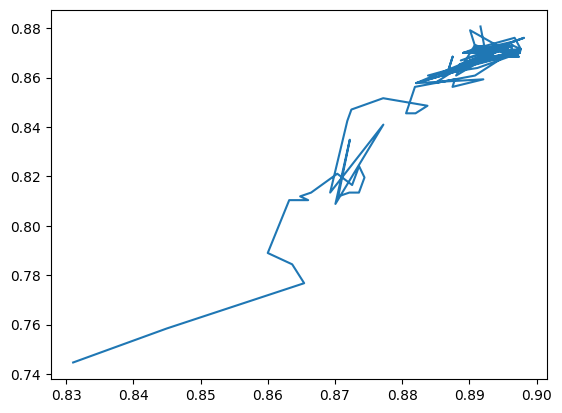

In [13]:
# Variant using Alexey's functions

possible_answers = [0.28, 0.48, 0.68, 0.88]

precissionList = []
recallList = []

treshhold = 0.5

for crt_c in np.arange(0.01,1.0,0.01):
    # avoid the rounding error
    crt_c = round(crt_c,2)
    
    #print(crt_c)
    dv, model = train(df_train, y_train, C=crt_c)
    y_val_pred = predict(df_val, dv, model)
    
    #print( y_val_pred)
    ###model = LogisticRegression(solver='liblinear', C=crt_c, max_iter=1000)
    ###model.fit(X_train, y_train)
    ###y_val_pred = model.predict(X_val)
    #fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
    
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_val_pred >= treshhold)
    predict_negative = (y_val_pred < treshhold)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp)
    recall =  tp / (tp + fn)
    
    #precision = precision_score(y_val, y_val_pred >= 0.5, average='weighted')
    #recall = recall_score(y_val, y_val_pred >= 0.5, average='weighted')
    
    precissionList.append(precision)
    recallList.append(recall)
    
    print(precision, recall)
    round_val = 3
    precision = round( precision, round_val )
    recall = round( precision, round_val )
    if precision == recall:
        print("FOUND crt_c=", crt_c ," precision=", precision, " recall=", recall )
        if crt_c in possible_answers:
            print("FOUND IN LIST ", crt_c) 
    #print( accuracy_score(y_val, y_val_pred >= 0.5) )
#print(precissionList)
#print(recallList)

plt.plot(precissionList, recallList)
#print("Done this step")

Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:
        
        F1 = 2 * P * R/ (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

    0.12
    0.32
    0.52
    0.72

ANSWER: 0.72

In [14]:
possible_answers = [0.12, 0.32, 0.52, 0.72]
maxF1 = 0
cForMaxF = 0
treshhold = 0.5
for crt_c in np.arange(0.01,1.0,0.01):
    # avoid the rounding error
    crt_c = round(crt_c,2) + 0.0
    model = LogisticRegression(solver='liblinear', C=crt_c, max_iter=1000)
    model.fit(X_train, y_train)
    #y_val_pred = model.predict(X_val)
    y_val_pred = model.predict_proba(X_val)[:, 1]
    #fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred  >= treshhold, average='weighted')
    recall = recall_score(y_val, y_val_pred  >= treshhold, average='weighted')
    round_val = 6
    #precision = round( precision, round_val)
    #recall = round( recall, round_val)
    F1 = 2 * precision * recall / (precision + recall)
    if F1 >= maxF1:
        #print( "Found new max F1; maxF1=", F1, " cForMaxF=",crt_c )
        #if crt_c in possible_answers:
        #    print("FOUND IN LIST ", crt_c)
        if F1 > maxF1:
            maxF1 = F1
            cForMaxF = crt_c
    if crt_c in possible_answers:
        print( "crt_c=", crt_c, " F1=", F1 )
print( "maxF1=", maxF1, " cForMaxF=",cForMaxF )

crt_c= 0.12  F1= 0.9185335193169534
crt_c= 0.32  F1= 0.9283927894250757
crt_c= 0.52  F1= 0.9305310271935054
crt_c= 0.72  F1= 0.9372737196769443
maxF1= 0.9385464589421831  cForMaxF= 0.6


In [15]:
# Variant using Alexey's functions

possible_answers = [0.12, 0.32, 0.52, 0.72]
maxF1 = 0
cForMaxF = 0
treshhold = 0.5
for crt_c in np.arange(0.01,1.0,0.01):
    # avoid the rounding error
    crt_c = round(crt_c,2) + 0.0
    
    dv, model = train(df_train, y_train, C=crt_c)
    y_val_pred = predict(df_val, dv, model)
    
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_val_pred >= treshhold)
    predict_negative = (y_val_pred < treshhold)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp)
    recall =  tp / (tp + fn)
    
    #precision = precision_score(y_val, y_val_pred >= 0.5, average='weighted')
    #recall = recall_score(y_val, y_val_pred >= 0.5, average='weighted')
    
    precissionList.append(precision)
    recallList.append(recall)
    
    print(precision, recall)
    #round_val = 3
    #precision = round( precision, round_val )
    #recall = round( precision, round_val )
    
    F1 = 2 * precision * recall / (precision + recall)
    if F1 >= maxF1:
        #print( "Found new max F1; maxF1=", F1, " cForMaxF=",crt_c )
        #if crt_c in possible_answers:
        #    print("FOUND IN LIST ", crt_c)
        if F1 > maxF1:
            maxF1 = F1
            cForMaxF = crt_c
    if crt_c in possible_answers:
        print( "crt_c=", crt_c, " F1=", F1 )
print( "maxF1=", maxF1, " cForMaxF=",cForMaxF )
    

0.8310580204778157 0.7446483180428135
0.8449744463373083 0.7584097859327217
0.8654173764906303 0.7767584097859327
0.8636363636363636 0.7844036697247706
0.86 0.7889908256880734
0.8631921824104235 0.8103975535168195
0.8660130718954249 0.8103975535168195
0.8648208469055375 0.8119266055045872
0.8664495114006515 0.8134556574923547
0.8703403565640194 0.8211009174311926
0.8725490196078431 0.8165137614678899
0.873581847649919 0.8241590214067278
crt_c= 0.12  F1= 0.8481510621557828
0.873581847649919 0.8241590214067278
0.8743882544861338 0.8195718654434251
0.8735632183908046 0.8134556574923547
0.8721311475409836 0.8134556574923547
0.8704918032786885 0.8119266055045872
0.8722044728434505 0.8348623853211009
0.8700657894736842 0.808868501529052
0.8771929824561403 0.8409785932721713
0.869281045751634 0.8134556574923547
0.8718354430379747 0.8425076452599388
0.8718354430379747 0.8425076452599388
0.8724409448818897 0.8470948012232415
0.8771653543307086 0.8516819571865444
0.8837579617834395 0.84862385321

Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

    Iterate over different folds of df_full_train
    Split the data into train and validation
    Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

    0.003
    0.030
    0.090
    0.140
    
ANSWER: 0.002

In [16]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []
C=1.0

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train[ 'above_average' ]
    y_val = df_val[ 'above_average' ]

    del df_train[ 'above_average' ]
    del df_val[ 'above_average' ]

    
    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.979 +- 0.002


Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

    Iterate over the following C values: [0.01, 0.1, 0.5, 10]
    Initialize KFold with the same parameters as previously
    Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

    0.01
    0.1
    0.5
    10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

ANSWER: C = 10

In [17]:
cList = [0.01, 0.1, 0.5, 10]

for C in cList:
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train[ 'above_average' ]
        y_val = df_val[ 'above_average' ]

        del df_train[ 'above_average' ]
        del df_val[ 'above_average' ]

    
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01 0.952 +- 0.003
C=0.1 0.972 +- 0.002
C=0.5 0.977 +- 0.002
C=10 0.981 +- 0.003
